In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import IPython
from keras_tuner import HyperModel
from kerastuner.tuners import Hyperband

C:\Users\jblee\AppData\Local\Temp/ipykernel_11548/1118916758.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [2]:
np.random.seed(2022)

### 데이터 생성하기

In [3]:
# =========================================
# 시계열 데이터 생성
# =========================================
n = 2349
p = 10
b_vec = np.arange(p,0,-1)/10
x_mat = np.random.normal(0,1,[n,p])
y_vec = np.dot(x_mat,b_vec) + np.random.normal(0,1,n)
# y_vec = y_vec.cumsum()
# y_vec = y_vec + abs(y_vec.min() )+ 100

In [4]:
# =========================================
# X ,Y 데이터 생성
# =========================================
columns = ["xvar_{}".format(x) for x in np.arange(0,10)]
xDF = pd.DataFrame(x_mat, columns = columns)
yDF = pd.DataFrame(y_vec,columns = ['Price'])
xyDF = pd.concat([xDF,yDF], axis = 1)

In [5]:
# =========================================
# Date 데이터 생성
# =========================================
xyDF['Date'] = pd.date_range(start = '2013-01-01', end = '2021-12-31', freq = '1B')

(array([15340., 15706., 16071., 16436., 16801., 17167., 17532., 17897.,
        18262., 18628., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

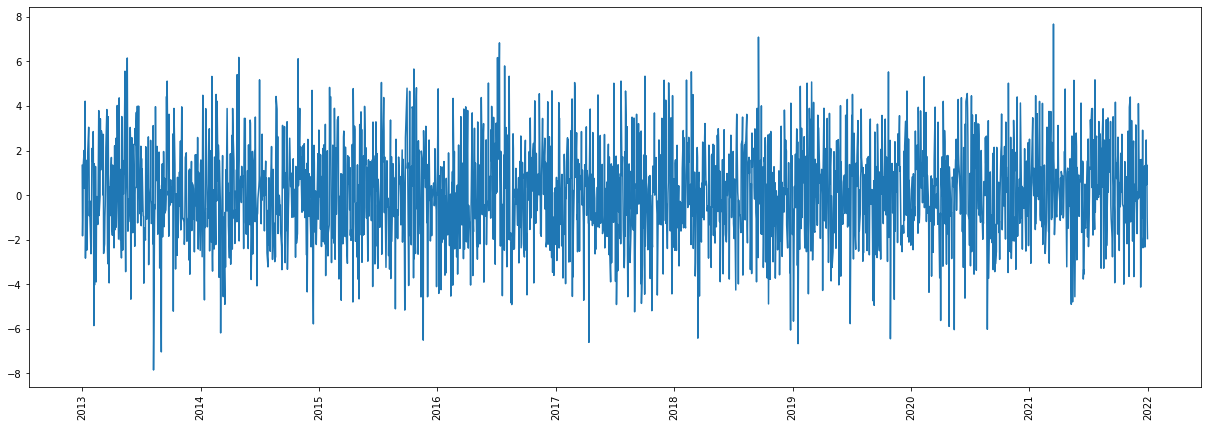

In [7]:
# =========================================
# Price 그래프 그려보기
# =========================================
plt.figure(figsize = [21,7])
plt.plot(xyDF['Date'], xyDF['Price'])
plt.xticks(rotation = 90)

### 데이터 전처리

In [8]:
# =========================================
# 65일 후 주가 예측 모델을 위한 데이터 전처리
# 학습      : 1040일(4년)
# Valdation : 65일(3개월)
# Test      : 65일 (3개월) 
# =========================================

model_code = 65
base_date = '20210101'

test_end_date = pd.date_range(base_date, periods=2, freq = "{}B".format(model_code))[1]
test_start_date = pd.date_range(test_end_date, periods = 2, freq = "-{}B".format(model_code))[1]
valid_end_date = pd.date_range(test_start_date, periods = 2, freq = "-1B".format(model_code))[1]
# valid_end_date = pd.date_range(test_start_date, periods = 2, freq = "-{}B".format(model_code))[1]
valid_start_date = pd.date_range(valid_end_date, periods = 2, freq = "-{}B".format(model_code))[1]
train_end_date = pd.date_range(valid_start_date, periods = 2, freq = "-{}B".format(1))[1]
train_start_date = pd.date_range(train_end_date, periods = 2, freq = "-{}B".format(1040))[1]


date_df = pd.DataFrame({"train_start" : train_start_date,
                        "train_end" : train_end_date,
                        "valid_start" : valid_start_date,
                        "valid_end" : valid_end_date,
                        "test_start" : test_start_date,
                        "test_end" : test_end_date}, index = [0])

date_df

,train_start,train_end,valid_start,valid_end,test_start,test_end
0,2016-10-05,2020-09-30,2020-10-01,2020-12-31,2021-01-01,2021-04-02


In [10]:
# =========================================
# Y 및 Y의 일자 생성
# =========================================
xyDF['Y'] = xyDF['Price'].shift(-1)
# xyDF['Y'] = xyDF['Price'].pct_change(65).shift(-65)
xyDF['Y_DATE'] = list(map(lambda xx : pd.date_range(xx, periods = 2, freq = '65B')[1],xyDF.Date))

In [11]:
# =========================================
# GRU X 데이터 생성을 위한 인덱스 Array 만들기
# EX)
#  : np.arange(0, 0 + nSteps * nInterval ,nInterval)
#  : np.arange(1, 1 + nSteps * nInterval ,nInterval)
#  : np.arange(2, 3 + nSteps * nInterval ,nInterval)
#  : np.arange(2209, 2209 + nSteps * nInterval ,nInterval)
#  : np.arange(x, x + nSteps * nInterval, nInterval)
# =========================================

nSteps = 15
nInterval = 10
dimBatch = len(xyDF) - nInterval*(nSteps - 1)
listidx = [np.arange(x, x + nSteps * nInterval, nInterval) for x in range(dimBatch)]

In [12]:
# =========================================
# GRU X, Y 데이터 생성
# =========================================

x_var = [s for s in xyDF.columns if 'xvar' in s]
#x_var = [s for s in xyDF.columns if 'Price' in s]
GRU_x = []
GRU_y = []
GRU_date = []

for i in range(dimBatch):
    
    ind = listidx[i]
    sub_xyDF = xyDF.iloc[ind,:]
    x = np.array(sub_xyDF[x_var])
    y = np.array(sub_xyDF.tail(1)['Y'])        # 해당 X의 가장 마지막 Y
    date = sub_xyDF.tail(1)[["Date","Y_DATE"]] # 해당 Y의 일자 -> Train, Valid, Test 구분을 위해 필요
    
    GRU_x.append(x)
    GRU_y.append(y)
    GRU_date.append(date)
    
    del(x,y,date,ind,sub_xyDF)
    
GRU_x = np.array(GRU_x)
GRU_y = np.array(GRU_y)
GRU_date = pd.concat(GRU_date)

In [13]:
print('X shape : ', GRU_x.shape)
print('y shape : ', GRU_y.shape)
print('date shape : ', GRU_date.shape)

X shape :  (2209, 15, 10)
y shape :  (2209, 1)
date shape :  (2209, 2)


In [14]:
# =========================================
# Train, Valid, Test 데이터로 분할
# =========================================

# 날짜 데이터 프레임으로 Train, Valid, Test Index 생성
Train_Index = (date_df.train_start[0] <= GRU_date.Y_DATE)& (GRU_date.Y_DATE <= date_df.train_end[0])
Valid_Index = (date_df.valid_start[0] <= GRU_date.Y_DATE)& (GRU_date.Y_DATE <= date_df.valid_end[0])
Test_Index = (date_df.test_start[0] <= GRU_date.Y_DATE)& (GRU_date.Y_DATE <= date_df.test_end[0])

# Train, Valid, Test 데이터 생성
Train_GRU_x = GRU_x[Train_Index,:,:]
Train_GRU_y = GRU_y[Train_Index,:]

Valid_GRU_x = GRU_x[Valid_Index,:,:]
Valid_GRU_y = GRU_y[Valid_Index,:]

Test_GRU_x = GRU_x[Test_Index,:,:]
Test_GRU_y = GRU_y[Test_Index,:]

In [15]:
# =========================================
# Min, Max Scale
# =========================================
# 각 Feature 별 Min Max 값 생성
Min_Max_DF = pd.DataFrame({})
for ind in range(Train_GRU_x.shape[2]):
    Max = Train_GRU_x[:,:,ind].max()
    Min = Train_GRU_x[:,:,ind].min()
    Min_Max_DF = pd.concat([Min_Max_DF, pd.DataFrame({"Feature_No": ind , "Max" : Max, "Min" : Min}, index = [0])])
    
Min_Max_DF.reset_index(drop = True, inplace = True)


# 각 Feature 별 Min Max Scale 진행
for ind in range(Train_GRU_x.shape[2]):
    # Train Min Max Scale
    Train_GRU_x[:,:,ind] = (Train_GRU_x[:,:,ind] - Min_Max_DF.iloc[ind,2])/(Min_Max_DF.iloc[ind,1] - Min_Max_DF.iloc[ind,2])

    # Valid Min Max Scale
    Valid_GRU_x[:,:,ind] = (Valid_GRU_x[:,:,ind] - Min_Max_DF.iloc[ind,2])/(Min_Max_DF.iloc[ind,1] - Min_Max_DF.iloc[ind,2])
    Valid_GRU_x[:,:,ind] = np.where(Valid_GRU_x[:,:,ind] >= 1 , 1, Valid_GRU_x[:,:,ind] ) # Train 에서 생성된 Max값으로 Scale 하기 때문에 
    Valid_GRU_x[:,:,ind] = np.where(Valid_GRU_x[:,:,ind] <= 0 , 0, Valid_GRU_x[:,:,ind] ) # Train 에서 생성된 Min값으로 Scale 하기 때문에

    # Test Min Max Scale
    Test_GRU_x[:,:,ind] = (Test_GRU_x[:,:,ind] - Min_Max_DF.iloc[ind,2])/(Min_Max_DF.iloc[ind,1] - Min_Max_DF.iloc[ind,2])
    Test_GRU_x[:,:,ind] = np.where(Test_GRU_x[:,:,ind] >= 1 , 1, Test_GRU_x[:,:,ind] ) # Train 에서 생성된 Max값으로 Scale 하기 때문에 
    Test_GRU_x[:,:,ind] = np.where(Test_GRU_x[:,:,ind] <= 0 , 0, Test_GRU_x[:,:,ind] ) # Train 에서 생성된 Min값으로 Scale 하기 때문에

In [17]:
# =========================================
# GRU HyperModel
# =========================================

class GRU_Model(HyperModel) :
    
    def __init__ (self, nSteps, nFeatures, nStacks, optimizer):
        self.nSteps        = nSteps
        self.nFeatures     = nFeatures
        self.nStacks       = nStacks
        self.optimizer     = optimizer
        

    def build(self, hp):
        
        # gru input layer
        layer_input = tf.keras.Input(shape = (self.nSteps, self.nFeatures), name = "input")
        
        # gru cell layer
        layer_state = tf.keras.layers.GRU(hp.Int('units', min_value = 32, max_value = 512, step = 32),return_state=True, name = 'gru_initial_state')(layer_input)[1]
        layer_gru   = tf.keras.layers.GRU(hp.Int('units', min_value = 32, max_value = 512, step = 32),return_sequences = True, name = 'gru_cell_0')(layer_input,initial_state = layer_state)
        
        if self.nStacks > 1 :
            for x in range(1 , self.nStacks) :
                layer_gru = tf.keras.layers.GRU(hp.Int('units', min_value = 32, max_value = 512, step = 32),return_sequences = True, name = 'gru_cell_{}'.format(x))(layer_gru)
        
        # gru output layer
        layer_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units = 1, activation = 'linear',
                                                                            kernel_regularizer = tf.keras.regularizers.l2(l=hp.Float('regularizers', min_value = 0.1, max_value = 0.5, step = 0.1)),
                                                                            kernel_initializer = tf.keras.initializers.orthogonal(seed = 1234))
                                                                      , name = 'output')(layer_gru)  
        # gru model
        gru_model = tf.keras.Model(layer_input, layer_output)
            
        # custom loss
        def custom_loss(y_true, y_pred):
            mean = tf.reduce_mean(abs(y_true - y_pred)**2)
            std  = 1/(tf.math.reduce_std(y_pred) + 1/mean)
            return mean + std**2
              
            
        # Optimizer
        if self.optimizer == "Adam":
            optim = tf.keras.optimizers.Adam(learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]))
        if self.optimizer == "RMSprop":
            optim = tf.keras.optimizers.RMSprop(learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]))

        # Compile   
        gru_model.compile(optimizer = optim, loss = custom_loss)
        
        return gru_model

In [18]:
# =============================
# Hyper Band Search
# =============================

# set paramegers
nSteps = 15
nFeatures = 10
nStacks = 3
optimizer = "RMSprop"
Patience = 30
epochs = 100

# Hyperband tuner setting
tuner = Hyperband(GRU_Model(nSteps,nFeatures,nStacks,optimizer),
                     objective = 'val_loss', 
                     max_epochs = 20,
                     factor = 3,
                     directory = 'D:/worksapce/OUT/hyper_model_gru',
                     project_name = 'gru_3')

# 
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)
        

# tuner Serach
tuner.search(Train_GRU_x, Train_GRU_y, epochs = epochs, validation_data = (Valid_GRU_x, Valid_GRU_y), callbacks = [ClearTrainingOutput()]
            ,verbose = 2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

Trial 30 Complete [00h 00m 12s]
val_loss: 7.033012390136719

Best val_loss So Far: 6.95543909072876
Total elapsed time: 00h 04m 17s
INFO:tensorflow:Oracle triggered exit


In [19]:
# Build the model with the optimal hyperparameters and train it on the data
gru_model = tuner.hypermodel.build(best_hps)

In [20]:
gru_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 15, 10)]     0           []                               
                                                                                                  
 gru_initial_state (GRU)        [(None, 256),        205824      ['input[0][0]']                  
                                 (None, 256)]                                                     
                                                                                                  
 gru_cell_0 (GRU)               (None, 15, 256)      205824      ['input[0][0]',                  
                                                                  'gru_initial_state[0][1]']      
                                                                                            

In [21]:
# Early Stopping
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = Patience, verbose = 1)

In [22]:
#'D:/workspace/PSC/MODEL/GRU_{epoch:02d}-{val_loss:.5f}.h5' -> epoch, val_loss 명으로 모델 저장
ModelCheck = tf.keras.callbacks.ModelCheckpoint(filepath = 'D:/workspace/PSC/MODEL/GRU_Model_01.h5'
                                                , monitor = 'val_loss'
                                                , mode = 'min'
                                                , save_best_only = True)

In [23]:
# 에폭 10까지 학습
gru_model.fit(Train_GRU_x, Train_GRU_y, epochs = 10, validation_data=(Valid_GRU_x, Valid_GRU_y))

Epoch 1/10
33/33 [==============================] - 5s 36ms/step - loss: 8.2378 - val_loss: 7.4337
Epoch 2/10
33/33 [==============================] - 0s 11ms/step - loss: 6.9333 - val_loss: 7.6307
Epoch 3/10
33/33 [==============================] - 0s 11ms/step - loss: 6.8968 - val_loss: 7.2218
Epoch 4/10
33/33 [==============================] - 0s 11ms/step - loss: 6.8154 - val_loss: 7.0516
Epoch 5/10
33/33 [==============================] - 0s 11ms/step - loss: 6.8025 - val_loss: 7.2081
Epoch 6/10
33/33 [==============================] - 0s 11ms/step - loss: 6.7485 - val_loss: 7.0276
Epoch 7/10
33/33 [==============================] - 0s 11ms/step - loss: 6.7311 - val_loss: 7.0110
Epoch 8/10
33/33 [==============================] - 0s 11ms/step - loss: 6.7184 - val_loss: 6.9943
Epoch 9/10
33/33 [==============================] - 0s 11ms/step - loss: 6.7209 - val_loss: 7.0011
Epoch 10/10
33/33 [==============================] - 0s 11ms/step - loss: 6.7021 - val_loss: 7.1404


In [24]:
# 에폭 10부터 학습
gru_model.fit(Train_GRU_x, Train_GRU_y
              , initial_epoch = 10
              , epochs = epochs
              , validation_data=(Valid_GRU_x, Valid_GRU_y)
              , callbacks = [EarlyStopping, ModelCheck])

Epoch 11/100
33/33 [==============================] - 0s 13ms/step - loss: 6.7003 - val_loss: 7.0414
Epoch 12/100
33/33 [==============================] - 0s 12ms/step - loss: 6.6858 - val_loss: 7.0024
Epoch 13/100
33/33 [==============================] - 0s 11ms/step - loss: 6.6799 - val_loss: 7.0145
Epoch 14/100
33/33 [==============================] - 0s 11ms/step - loss: 6.6700 - val_loss: 7.2295
Epoch 15/100
33/33 [==============================] - 0s 11ms/step - loss: 6.6861 - val_loss: 7.0715
Epoch 16/100
33/33 [==============================] - 0s 13ms/step - loss: 6.6822 - val_loss: 6.9836
Epoch 17/100
33/33 [==============================] - 0s 11ms/step - loss: 6.6797 - val_loss: 7.0083
Epoch 18/100
33/33 [==============================] - 0s 11ms/step - loss: 6.6714 - val_loss: 6.9912
Epoch 19/100
33/33 [==============================] - 0s 11ms/step - loss: 6.6701 - val_loss: 7.0034
Epoch 20/100
33/33 [==============================] - 0s 11ms/step - loss: 6.6685 - val_los

33/33 [==============================] - 0s 11ms/step - loss: 3.8327 - val_loss: 7.1203
Epoch 92/100
33/33 [==============================] - 0s 11ms/step - loss: 3.6975 - val_loss: 7.0408
Epoch 93/100
33/33 [==============================] - 0s 12ms/step - loss: 3.6286 - val_loss: 7.8380
Epoch 94/100
33/33 [==============================] - 0s 11ms/step - loss: 3.4799 - val_loss: 8.4311
Epoch 95/100
33/33 [==============================] - 0s 11ms/step - loss: 3.4062 - val_loss: 7.7740
Epoch 96/100
33/33 [==============================] - 0s 11ms/step - loss: 3.3451 - val_loss: 7.3974
Epoch 97/100
33/33 [==============================] - 0s 11ms/step - loss: 3.3360 - val_loss: 7.7408
Epoch 98/100
33/33 [==============================] - 0s 11ms/step - loss: 3.1771 - val_loss: 7.9323
Epoch 99/100
33/33 [==============================] - 0s 11ms/step - loss: 3.1888 - val_loss: 7.6528
Epoch 100/100
33/33 [==============================] - 0s 11ms/step - loss: 3.0669 - val_loss: 7.9690


In [25]:
# GRU MODEL 불러오기
model_01 = tf.keras.models.load_model('D:/workspace/PSC/MODEL/GRU_Model_01.h5', compile=False)

In [26]:
# Prediction Value
Prediction = model_01.predict(Test_GRU_x)

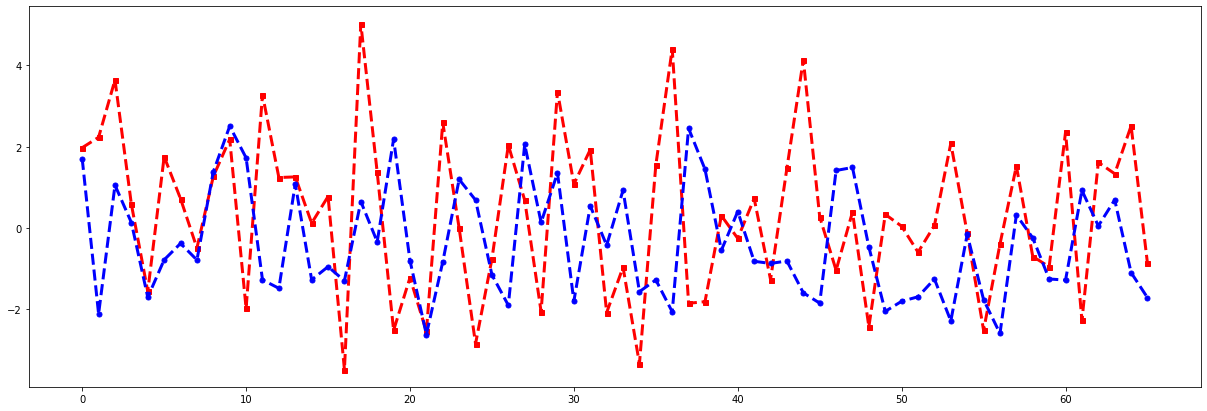

In [27]:
# Plot
plt.figure(figsize = (21,7))
plt.plot(Test_GRU_y, 'rs--', lw = 3, ms = 5)
plt.plot(Prediction[:,14,:], 'bo--', lw = 3, ms = 5)